In [2]:
import pandas as pd
import numpy as np

# Fundamental data preprocessing


In [3]:
# CSV of publically traded healthcare companies as classified by GIC subindustry codes
df = pd.read_csv('healthcare_fundamentals_v3.csv') #update w/ latest version

key_table = df[['cik', 'GVKEY']] #keys to join all databases
key_table.head()

C:\Users\Hannah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (23,33,37,955,956,957,962,976,977) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cik,GVKEY
0,319126.0,1021
1,319126.0,1021
2,319126.0,1021
3,319126.0,1021
4,319126.0,1021


In [4]:
#all companies in healthcare industry from 2000 - 2010
print('Total number of unique companies from 2000 - 2010:',df['GVKEY'].nunique())

Total number of unique companies from 2000 - 2010: 1975


In [5]:
#eliminate private companies (ipodate = nan)
mask = df['ipodate'].isna()
print(mask.sum())
print(df.shape)
print(df[-mask].shape)
df = df[-mask]

5251
(14065, 988)
(8814, 988)


In [6]:
#number of public healthcare companies
print('Total number of unique public companies from 2000 - 2010:',df['GVKEY'].nunique())

Total number of unique public companies from 2000 - 2010: 1175


In [7]:
#eliminate rows with no market cap information
mask = df['mkvalt'].isna()
df = df[-mask]
print('Total number of unique private companies with market cap from 2000 - 2010:',df['GVKEY'].nunique())

Total number of unique private companies with market cap from 2000 - 2010: 1055


In [8]:
# df['year'] =  pd.to_datetime(df['datadate']).dt.year
# mask = df['year'] == 2000

# df[mask]['GVKEY'].value_counts()

In [9]:
df['year'] =  pd.to_datetime(df['datadate']).dt.year
df = df.drop_duplicates(['year','GVKEY'])

In [10]:
df.head()

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyear,...,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate,year
40,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2000,2000.0,...,6324,287.0,905.0,B+,CT,0.0,www.aetna.com,11/29/2018,09/24/1968,2000
41,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2001,2001.0,...,6324,287.0,905.0,B+,CT,0.0,www.aetna.com,11/29/2018,09/24/1968,2001
43,1177,J,03,NR,NaN,NaN,06/29/2001,01/31/2006,12/31/2002,2002.0,...,6324,287.0,905.0,B+,CT,0.0,www.aetna.com,11/29/2018,09/24/1968,2002
45,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2003,2003.0,...,6324,287.0,905.0,B+,CT,0.0,www.aetna.com,11/29/2018,09/24/1968,2003
47,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2004,2004.0,...,6324,287.0,905.0,B+,CT,0.0,www.aetna.com,11/29/2018,09/24/1968,2004


In [11]:
print('Total number of unique private companies with market cap from 2000 - 2010:',df['GVKEY'].nunique())

Total number of unique private companies with market cap from 2000 - 2010: 1055


# Read in Bankruptcy Data and Merge with Fundamentals

In [12]:
# Bankrupt healthcare companies
df_bankrupt = pd.read_csv('healthcare_bankrupt_audit_analytics_v2.csv')

In [13]:
print('Total of:' ,len(df_bankrupt), "bankruptcy filings")

Total of: 187 bankruptcy filings


In [14]:
#create year column
df_bankrupt['bankrupt_year'] = pd.to_datetime(df_bankrupt['BANK_BEGIN_DATE']).dt.year

#filter for year 2001- 2010
mask = (df_bankrupt['bankrupt_year'] >2000) &  (df_bankrupt['bankrupt_year']  < 2011)
df_bankrupt = df_bankrupt[mask]


In [15]:
print('Total of:' ,len(df_bankrupt), "bankruptcy filings between 2001 and 2010")

Total of: 129 bankruptcy filings between 2001 and 2010


In [16]:
# Get chapter 11 companies only
df_bankrupt= df_bankrupt[df_bankrupt['BANKRUPTCY_TYPE']==11]
print('Total of:' ,len(df_bankrupt), "CH 11 bankruptcy filings between 2001 and 2010")

Total of: 82 CH 11 bankruptcy filings between 2001 and 2010


In [17]:
df_bankrupt['bankrupt_year'].value_counts().sort_index().plot(kind = 'bar', title = 'Number of CH11 Bankruptcies by Year')

# Merge Financial Ratios

In [18]:
#create cik - GVKEY table from fundamentals dataset
key_table = key_table.drop_duplicates()
key_table.head()

,cik,GVKEY
0,319126.0,1021
9,730469.0,1034
17,1800.0,1078
28,2034.0,1094
39,313798.0,1115


In [19]:
df_fin_ratio = pd.read_csv('fin ratios.csv')
df_fin_ratio['gvkey'].nunique()

1244

In [20]:
bankrupt_key  = pd.merge(df_bankrupt, key_table, left_on = 'COMPANY_FKEY', right_on = 'cik', suffixes = ('_ratio', '_key'), how = 'inner')
# df_table = df_table.drop_duplicates()

In [21]:
bankrupt_key.shape

(82, 467)

In [23]:
fin_ratio_bankruptcy = pd.merge(df_fin_ratio, bankrupt_key, left_on = 'gvkey', right_on = 'GVKEY', suffixes = ('_finratio', '_bankrupt'), how = 'left')

In [24]:
#processing for fin ratio to drop duplicates
fin_ratio_bankruptcy['year'] = pd.to_datetime(fin_ratio_bankruptcy['adate']).dt.year
df_fin_ratio=df_fin_ratio.drop_duplicates(subset=['gvkey','qdate'], keep='last')
df_fin_ratio['qmonth']=pd.to_datetime(df_fin_ratio['qdate']).dt.month
mask= df_fin_ratio['qmonth']==12
df_fin_ratio= df_fin_ratio[mask]

df_fin_ratio.shape

(7526, 76)

In [25]:
fin_ratio_bankruptcy.shape

(95215, 543)

In [26]:
#create bankruptcy dummy
#adate is year end date
mask = pd.to_datetime(fin_ratio_bankruptcy['adate']).dt.year + 1 == pd.to_datetime(fin_ratio_bankruptcy['BANK_BEGIN_DATE']).dt.year

fin_ratio_bankruptcy['bankrupted'] = np.where(mask, 1,0)

In [27]:
fin_ratio_bankruptcy['gvkey'].nunique()

1244

In [28]:
fin_ratio_bankruptcy['year'] = pd.to_datetime(fin_ratio_bankruptcy['adate']).dt.year

In [29]:
fund_ratio_bank  = pd.merge(df, fin_ratio_bankruptcy, left_on = ['GVKEY', 'year'], right_on = ['gvkey', 'year'], suffixes = ('_fund', '_ratio'), how = 'inner')
fund_ratio_bank = fund_ratio_bank.drop(columns = 'GVKEY_ratio')
fund_ratio_bank = fund_ratio_bank.rename(columns = {'GVKEY_fund' : 'GVKEY'})


In [30]:
print('The final dataset includes:',fund_ratio_bank['GVKEY'].nunique(), 'companies, which have fundamental as well as financial ratios values')

The final dataset includes: 855 companies, which have fundamental as well as financial ratios values


In [31]:
fund_ratio_bank.head()

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyear,...,HIWATER_INCMST_NETINC_TTM_DATE,HIWATER_INCMST_NETINC_TTM,HIWATER_INCMST_NETINC_FY_DATE,HIWATER_INCMST_NETINC_FY,NAME_CHANGE_DATE1,NAME_CHANGE_DATE2,NAME_CHANGE_DATE3,bankrupt_year,cik_ratio,bankrupted
0,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2000,2000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2000,2000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2000,2000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2000,2000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2000,2000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [32]:
#filter for market cap size (in MM)
#recommend using this after creating bankruptcy dummy

def market_cap_size(df, lower, upper):
    
    mask = ((df['mkvalt'] >=lower) & (df['mkvalt'] <=upper))
    df =df[mask]
    
    return df


#market cap 500M - 1B
df500 = market_cap_size(fund_ratio_bank, 0,1000)

df500['GVKEY'].nunique()

784

In [33]:
df500['bankrupted'].sum()

150

In [34]:
# get list of financial ratio that could be used as input
listratio=[]
for col in df_fin_ratio.columns: 
    listratio.append(col) 


In [36]:
for i in listratio:
    print(i,":",df500[i].max())

gvkey : 271794
adate : 12/31/2009
qdate : 12/31/2009
public_date : 12/31/2010
CAPEI : 13971.9
bm : 27.778000000000002
evm : 160265.0
pe_op_basic : 730.0
pe_op_dil : 774.6669999999999
pe_exi : 774.6669999999999
pe_inc : 750.0
ps : 435.69199999999995
pcf : 452.796
dpr : 19256.7
npm : 68.516
opmbd : 0.937
opmad : 0.934
gpm : 1.0
ptpm : 68.516
cfm : 71.889
roa : 1.6019999999999999
roe : 75.706
roce : 1359.14
efftax : 48.062
aftret_eq : 347.61300000000006
aftret_invcapx : 275.086
aftret_equity : 347.61300000000006
pretret_noa : 231.696
pretret_earnat : 2.436
GProf : 3.1189999999999998
equity_invcap : 166.02900000000002
debt_invcap : 207.231
totdebt_invcap : 675.538
capital_ratio : 346.47900000000004
int_debt : 1162.0
int_totdebt : 2092.0
cash_lt : 317.675
invt_act : 1.001
rect_act : 0.972
debt_at : 4.821000000000001
debt_ebitda : 3340.75
short_debt : 1.272
curr_debt : 1.351
lt_debt : 0.9620000000000001
profit_lct : 17.590999999999998
ocf_lct : 27.826999999999998
cash_debt : 20.612
fcf_ocf :

TypeError: '>=' not supported between instances of 'float' and 'str'

In [37]:
for i in listratio:
    print(i,"NULL:",df500[i].isnull().sum())

gvkey NULL: 0
adate NULL: 0
qdate NULL: 0
public_date NULL: 0
CAPEI NULL: 1340
bm NULL: 3069
evm NULL: 91
pe_op_basic NULL: 943
pe_op_dil NULL: 928
pe_exi NULL: 925
pe_inc NULL: 918
ps NULL: 2843
pcf NULL: 171
dpr NULL: 32598
npm NULL: 2843
opmbd NULL: 2843
opmad NULL: 2843
gpm NULL: 3169
ptpm NULL: 2843
cfm NULL: 2901
roa NULL: 176
roe NULL: 3541
roce NULL: 326
efftax NULL: 33737
aftret_eq NULL: 167
aftret_invcapx NULL: 1008
aftret_equity NULL: 167
pretret_noa NULL: 391
pretret_earnat NULL: 391
GProf NULL: 36
equity_invcap NULL: 743
debt_invcap NULL: 879
totdebt_invcap NULL: 888
capital_ratio NULL: 136
int_debt NULL: 17611
int_totdebt NULL: 14950
cash_lt NULL: 44
invt_act NULL: 354
rect_act NULL: 701
debt_at NULL: 145
debt_ebitda NULL: 236
short_debt NULL: 12808
curr_debt NULL: 244
lt_debt NULL: 136
profit_lct NULL: 238
ocf_lct NULL: 370
cash_debt NULL: 549
fcf_ocf NULL: 29062
lt_ppent NULL: 392
dltt_be NULL: 2765
debt_assets NULL: 44
debt_capital NULL: 27
de_ratio NULL: 44
intcov NUL

KeyError: 'qmonth'

In [38]:
df500['curr_debt']

251      0.348
252      0.348
253      0.348
254      0.481
255      0.481
         ...  
59959    0.728
59960    0.728
59961    0.728
59962    1.000
59963    1.000
Name: curr_debt, Length: 49311, dtype: float64

In [39]:
#de_ratio, debt_ebitda, roa, cash_debt, quick_ratio, intcov_ratio

In [40]:
df_dataset= df500[['de_ratio', 'debt_ebitda', 'roa', 'cash_debt', 'quick_ratio', 'intcov_ratio','bankrupted','adate']]

In [41]:
df_dataset=df_dataset.dropna()

In [42]:
df_dataset

,de_ratio,debt_ebitda,roa,cash_debt,quick_ratio,intcov_ratio,bankrupted,adate
251,0.338,1.333,0.079,0.309,8.660,87.403,0,12/31/2000
252,0.338,1.333,0.079,0.309,8.660,87.403,0,12/31/2000
253,0.338,1.333,0.079,0.309,8.660,87.403,0,12/31/2000
254,0.335,1.333,0.147,0.309,6.270,87.403,0,12/31/2000
255,0.335,1.333,0.147,0.309,6.270,87.403,0,12/31/2000
...,...,...,...,...,...,...,...,...
59959,0.103,-0.048,-0.286,-4.238,12.082,-26.559,0,12/31/2009
59960,0.103,-0.048,-0.286,-4.238,12.082,-26.559,0,12/31/2009
59961,0.103,-0.048,-0.286,-4.238,12.082,-26.559,0,12/31/2009
59962,0.071,0.000,-0.257,-4.238,12.353,-57.240,0,12/31/2009


In [43]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pandas import Series, DataFrame
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,recall_score
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error
import seaborn as sns

#presentation: start w/ abstract

In [44]:
df_dataset

,de_ratio,debt_ebitda,roa,cash_debt,quick_ratio,intcov_ratio,bankrupted,adate
251,0.338,1.333,0.079,0.309,8.660,87.403,0,12/31/2000
252,0.338,1.333,0.079,0.309,8.660,87.403,0,12/31/2000
253,0.338,1.333,0.079,0.309,8.660,87.403,0,12/31/2000
254,0.335,1.333,0.147,0.309,6.270,87.403,0,12/31/2000
255,0.335,1.333,0.147,0.309,6.270,87.403,0,12/31/2000
...,...,...,...,...,...,...,...,...
59959,0.103,-0.048,-0.286,-4.238,12.082,-26.559,0,12/31/2009
59960,0.103,-0.048,-0.286,-4.238,12.082,-26.559,0,12/31/2009
59961,0.103,-0.048,-0.286,-4.238,12.082,-26.559,0,12/31/2009
59962,0.071,0.000,-0.257,-4.238,12.353,-57.240,0,12/31/2009


In [45]:
mask_test = pd.to_datetime(df_dataset['adate']).dt.year >=2007
train=df_dataset[~mask_test]
test=df_dataset[mask_test]

In [46]:
train= train.drop(columns='adate')
test= test.drop(columns='adate')

In [47]:
y_train= train['bankrupted']
train= train.drop(columns=['bankrupted'])


In [48]:
x_train= train

## Random  Forest

In [49]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=2, random_state=0, class_weight='balanced')

rgr=clf.fit(x_train, y_train)

In [50]:
pred_train=rgr.predict(x_train)
accuracy_score(pred_train, y_train)

0.9168449197860963

In [51]:
y_test= test['bankrupted']
test= test.drop(columns=['bankrupted'])
x_test= test

In [52]:
pred_test=rgr.predict(x_test)
accuracy_score(pred_test, y_test)

0.9076110866695997

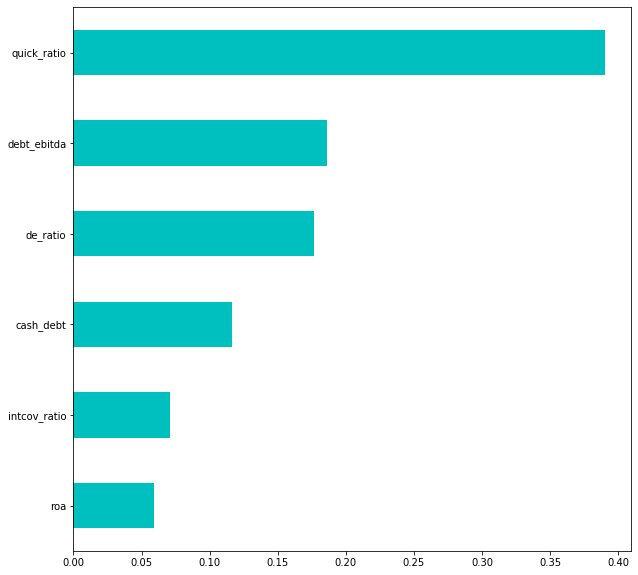

In [53]:
feat_importances = pd.Series(rgr.feature_importances_, index=x_train.columns)
plt.figure(figsize=(10,10)) 
feat_importances.sort_values().plot(kind='barh',color='c')
#feat_importances.sort_values(ascending=False)

## Logistic Regression 

In [54]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5,class_weight='balanced')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(x_train, y_train)

C:\Users\Hannah\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
y_pred=logreg.predict(x_test)

In [56]:
accuracy_score(y_pred, y_test)

0.5137483501979763

In [57]:
feature_importance = abs(logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

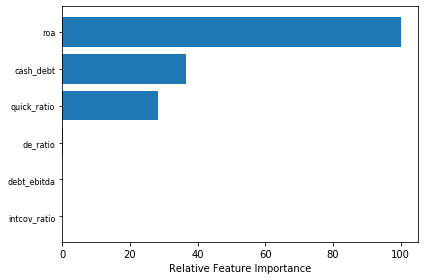

In [58]:
featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(x_train.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [59]:
import numpy as np
from sklearn.metrics import precision_recall_curve

In [60]:
y_score = logreg.decision_function(x_test)

In [61]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.08


In [62]:
df_bankrupt.drop_duplicates()

,COMPANY_FKEY,BANK_KEY,SUBSID_NAME,BANKRUPTCY_TYPE,LAW_COURT_FKEY,COURT_TYPE_CODE,COURT_NAME,COURT_S_NAME,COURT_LOC_STREET,COURT_LOC_CITY,...,HIWATER_INCMST_NETINC_QTR_DATE,HIWATER_INCMST_NETINC_QTR,HIWATER_INCMST_NETINC_TTM_DATE,HIWATER_INCMST_NETINC_TTM,HIWATER_INCMST_NETINC_FY_DATE,HIWATER_INCMST_NETINC_FY,NAME_CHANGE_DATE1,NAME_CHANGE_DATE2,NAME_CHANGE_DATE3,bankrupt_year
1,19411,196,NaN,11,148,1,New York Southern Bankruptcy Court,NY SBC,NaN,NaN,...,2003-12-31,499948000.0,2004-09-30,567866000.0,2003-12-31,499948000.0,2014-07-01,1996-02-14,NaN,2003
8,353827,534,NaN,11,108,1,Delaware Bankruptcy Court,DE BC,NaN,NaN,...,2005-01-01,0.0,2001-06-30,14600000.0,2001-06-30,NaN,NaN,NaN,NaN,2005
10,356830,1164,NaN,11,133,1,Massachusetts Bankruptcy Court,MA BC,NaN,NaN,...,2007-06-30,16277000.0,2000-08-31,-2816050.0,2000-08-31,NaN,2004-04-08,NaN,NaN,2009
11,357097,1155,NaN,11,108,1,Delaware Bankruptcy Court,DE BC,NaN,NaN,...,2019-06-30,11743000.0,2019-06-30,3595000.0,2000-12-31,0.0,2009-09-14,2001-08-22,NaN,2009
12,704384,1054,NaN,11,110,1,Florida Middle Bankruptcy Court,FL MBC,NaN,NaN,...,2010-09-30,0.0,2010-09-30,-8173000.0,2010-09-30,0.0,2001-05-16,NaN,NaN,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,1330487,1397,NaN,11,108,1,Delaware Bankruptcy Court,DE BC,NaN,NaN,...,2007-12-28,0.0,2007-12-28,2326382.0,NaN,NaN,2007-11-15,NaN,NaN,2010
171,1340752,1441,NaN,11,133,1,Massachusetts Bankruptcy Court,MA BC,NaN,NaN,...,2005-12-31,0.0,2007-12-31,-59825181.0,2007-12-31,-21654318.0,NaN,NaN,NaN,2010
175,1355804,2285,NaN,11,108,1,Delaware Bankruptcy Court,DE BC,NaN,NaN,...,2008-12-31,0.0,2005-12-31,-10240000.0,2005-12-31,0.0,NaN,NaN,NaN,2010
177,1375098,2297,NaN,11,184,1,Minnesota Bankruptcy Court,MN BC,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-13,NaN,NaN,2004


In [63]:
relevant_columns = df_bankrupt[['COMPANY_FKEY','FILE_DATE']]
#list(df_bankrupt.columns)
df['cik'][:5]

# COMPANY_FKEY is CIK
df_bankrupt['COMPANY_FKEY'][:5]

df_bankrupt['COMPANY_FKEY'].nunique()

#filter for 2000-2010
mask = (pd.to_datetime(df_bankrupt['BANK_BEGIN_DATE']).dt.year >1999) &  (pd.to_datetime(df_bankrupt['BANK_BEGIN_DATE']).dt.year < 2011)

df_bankrupt_2000 = df_bankrupt[mask]

df_bankrupt_2000.head()

,COMPANY_FKEY,BANK_KEY,SUBSID_NAME,BANKRUPTCY_TYPE,LAW_COURT_FKEY,COURT_TYPE_CODE,COURT_NAME,COURT_S_NAME,COURT_LOC_STREET,COURT_LOC_CITY,...,HIWATER_INCMST_NETINC_QTR_DATE,HIWATER_INCMST_NETINC_QTR,HIWATER_INCMST_NETINC_TTM_DATE,HIWATER_INCMST_NETINC_TTM,HIWATER_INCMST_NETINC_FY_DATE,HIWATER_INCMST_NETINC_FY,NAME_CHANGE_DATE1,NAME_CHANGE_DATE2,NAME_CHANGE_DATE3,bankrupt_year
1,19411,196,NaN,11,148,1,New York Southern Bankruptcy Court,NY SBC,NaN,NaN,...,2003-12-31,499948000.0,2004-09-30,567866000.0,2003-12-31,499948000.0,2014-07-01,1996-02-14,NaN,2003
8,353827,534,NaN,11,108,1,Delaware Bankruptcy Court,DE BC,NaN,NaN,...,2005-01-01,0.0,2001-06-30,14600000.0,2001-06-30,NaN,NaN,NaN,NaN,2005
10,356830,1164,NaN,11,133,1,Massachusetts Bankruptcy Court,MA BC,NaN,NaN,...,2007-06-30,16277000.0,2000-08-31,-2816050.0,2000-08-31,NaN,2004-04-08,NaN,NaN,2009
11,357097,1155,NaN,11,108,1,Delaware Bankruptcy Court,DE BC,NaN,NaN,...,2019-06-30,11743000.0,2019-06-30,3595000.0,2000-12-31,0.0,2009-09-14,2001-08-22,NaN,2009
12,704384,1054,NaN,11,110,1,Florida Middle Bankruptcy Court,FL MBC,NaN,NaN,...,2010-09-30,0.0,2010-09-30,-8173000.0,2010-09-30,0.0,2001-05-16,NaN,NaN,2008


In [64]:
df_merge = pd.merge(df, df_bankrupt_2000, left_on = 'cik', right_on = 'COMPANY_FKEY', suffixes = ('_fundam', '_bank'), how = 'left')
df_merge['cik'].nunique()

965

In [65]:
# df_merge_11 = df_merge[df_merge['BANKRUPTCY_TYPE']==11]
# df_merge_11

In [66]:
df_merge.head()

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyear,...,HIWATER_INCMST_NETINC_QTR_DATE,HIWATER_INCMST_NETINC_QTR,HIWATER_INCMST_NETINC_TTM_DATE,HIWATER_INCMST_NETINC_TTM,HIWATER_INCMST_NETINC_FY_DATE,HIWATER_INCMST_NETINC_FY,NAME_CHANGE_DATE1,NAME_CHANGE_DATE2,NAME_CHANGE_DATE3,bankrupt_year
0,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2000,2000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2001,2001.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1177,J,03,NR,NaN,NaN,06/29/2001,01/31/2006,12/31/2002,2002.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2003,2003.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1177,P,01,LC,88845.0,41072.0,12/14/2000,11/30/2018,12/31/2004,2004.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
df_test = df_merge[df_merge['cik'] ==815508]

In [68]:
df_test.head()

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyear,...,HIWATER_INCMST_NETINC_QTR_DATE,HIWATER_INCMST_NETINC_QTR,HIWATER_INCMST_NETINC_TTM_DATE,HIWATER_INCMST_NETINC_TTM,HIWATER_INCMST_NETINC_FY_DATE,HIWATER_INCMST_NETINC_FY,NAME_CHANGE_DATE1,NAME_CHANGE_DATE2,NAME_CHANGE_DATE3,bankrupt_year
5302,122315,P,01,LC,87057.0,16691.0,07/30/1999,07/21/2009,10/31/2000,2000.0,...,2006-10-31,-6281000.0,2009-04-28,-14692330.0,2008-10-28,NaN,NaN,NaN,NaN,2009.0
5303,122315,P,01,LC,87057.0,16691.0,07/30/1999,07/21/2009,10/31/2001,2001.0,...,2006-10-31,-6281000.0,2009-04-28,-14692330.0,2008-10-28,NaN,NaN,NaN,NaN,2009.0
5304,122315,P,01,LC,87057.0,16691.0,07/30/1999,07/21/2009,10/31/2002,2002.0,...,2006-10-31,-6281000.0,2009-04-28,-14692330.0,2008-10-28,NaN,NaN,NaN,NaN,2009.0
5305,122315,P,01,LC,87057.0,16691.0,07/30/1999,07/21/2009,10/31/2003,2003.0,...,2006-10-31,-6281000.0,2009-04-28,-14692330.0,2008-10-28,NaN,NaN,NaN,NaN,2009.0
5306,122315,P,01,LC,87057.0,16691.0,07/30/1999,07/21/2009,10/31/2004,2004.0,...,2006-10-31,-6281000.0,2009-04-28,-14692330.0,2008-10-28,NaN,NaN,NaN,NaN,2009.0


In [69]:
mask = pd.to_datetime(df_merge['datadate']).dt.year + 1 == pd.to_datetime(df_merge['BANK_BEGIN_DATE']).dt.year

df_merge['bankrupted'] = np.where(mask, 1,0)

In [70]:
df_merge['bankrupted']

0       0
1       0
2       0
3       0
4       0
       ..
7243    0
7244    0
7245    0
7246    0
7247    0
Name: bankrupted, Length: 7248, dtype: int32

In [75]:
mask = pd.to_datetime(df_merge['datadate']).dt.year + 1 == pd.to_datetime(df_merge['BANK_BEGIN_DATE']).dt.year
df_merge[mask][:5]

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyear,...,HIWATER_INCMST_NETINC_QTR,HIWATER_INCMST_NETINC_TTM_DATE,HIWATER_INCMST_NETINC_TTM,HIWATER_INCMST_NETINC_FY_DATE,HIWATER_INCMST_NETINC_FY,NAME_CHANGE_DATE1,NAME_CHANGE_DATE2,NAME_CHANGE_DATE3,bankrupt_year,bankrupted
76,3171,P,01,LC,24548.0,5308.0,06/30/1982,07/20/2009,12/31/2008,2008.0,...,16277000.0,2000-08-31,-2816050.0,2000-08-31,NaN,2004-04-08,NaN,NaN,2009.0,1
321,12879,C,01,NR,NaN,NaN,03/18/1999,07/31/2004,12/31/2001,2001.0,...,958488.0,2004-12-31,16907.0,2004-12-31,-162188.0,NaN,NaN,NaN,2002.0,1
368,13071,P,01,NR,NaN,NaN,04/13/1995,02/13/2007,10/31/2002,2002.0,...,54265000.0,2012-12-31,66310000.0,2012-12-31,54265000.0,2006-11-21,NaN,NaN,2003.0,1
429,13282,C,01,LU,10928.0,8805.0,12/11/1986,08/20/2002,12/31/2001,2001.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002.0,1
662,14581,P,01,LC,75580.0,9849.0,08/05/1988,09/30/2002,12/31/2001,2001.0,...,3423000.0,2016-01-31,4513000.0,2015-10-31,1012000.0,2012-08-21,NaN,NaN,2002.0,1


In [76]:
df_merge['cik'].nunique()

965

In [77]:
pd.to_datetime(df_merge['datadate']).dt.year + 1

0       2001
1       2002
2       2003
3       2004
4       2005
        ... 
7243    2009
7244    2010
7245    2011
7246    2010
7247    2011
Name: datadate, Length: 7248, dtype: int64

In [78]:
# np.where()

TypeError: where() missing 1 required positional argument: 'condition'

In [ ]:
pd.to_datetime(df_test['BANK_BEGIN_DATE']).dt.year

In [ ]:
df_test['BANK_BEGIN_DATE'][:5]

In [ ]:
df_merge.head()